<a href="https://colab.research.google.com/github/spiyer99/simpsonification/blob/master/StyleGAN_blending_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network blending in StyleGAN

Swapping layers between two models in StyleGAN gives some interesting results. You need a base model and a second model which has been fine-tuned from the base.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
my_drive = GoogleDrive(gauth)

In [ ]:
!pip install -q ipython-autotime
%load_ext autotime 

time: 155 µs (started: 2021-01-22 20:16:35 +00:00)


In [ ]:
!git clone https://github.com/justinpinkney/stylegan2.git

Cloning into 'stylegan2'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 2.32 MiB | 4.19 MiB/s, done.
Resolving deltas: 100% (141/141), done.
time: 1.71 s (started: 2021-01-22 20:16:35 +00:00)


In [ ]:
%cd stylegan2

/content/stylegan2
time: 4.1 ms (started: 2021-01-22 20:16:37 +00:00)


In [ ]:
%tensorflow_version 1.x
!pip install typer

TensorFlow 1.x selected.
time: 2.4 s (started: 2021-01-22 20:16:37 +00:00)


Command line help for the blending function is below. Make sure that you specify either `--output-grid` to save an example image or `--output-pkl` to save the modified pkl. (Currently only the the Gs network is modified)

- low_res_pkl: Path, # Pickle file from which to take low res layers
- high_res_pkl: Path, # Pickle file from which to take high res layers
- resolution: int, # Resolution level at which to switch between models
- level: int  = 0, # Switch at Conv block 0 or 1?
- blend_width: Optional[float] = None, # None = hard switch, float = smooth switch (logistic) with given width
- output_grid: Optional[Path] = "blended.jpg", # Path of image file to save example grid (None = don't save)
- seed: int = 0, # seed for random grid
- output_pkl: Optional[Path] = None, # Output path of pickle (None = don't save)
- verbose: bool = False, # Print out the exact blending fraction

         

Use as an example a model I fine-tuned at 256 from FFHQ to data scraped from NASA DSCOVR:EPIC satellite (https://epic.gsfc.nasa.gov/).

For the output of the fine-tuned model see the tweet below (https://twitter.com/Buntworthy/status/1295445259971899393)

I'm actually going to use a model from earlier in training than the result shown in the tweet, this makes the blending a bit nicer.

In [ ]:
# %%html
# <blockquote class="twitter-tweet"><p lang="en" dir="ltr">Not sure what I was expecting, but definitely forgot to turn mirror augmentation off. <a href="https://t.co/qO5ySH2TxT">pic.twitter.com/qO5ySH2TxT</a></p>&mdash; Justin (@Buntworthy) <a href="https://twitter.com/Buntworthy/status/1295445259971899393?ref_src=twsrc%5Etfw">August 17, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

time: 908 µs (started: 2021-01-22 20:16:39 +00:00)


In [ ]:
# ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"
# ffhq_url = "https://hanlab.mit.edu/projects/data-efficient-gans/models/stylegan2-ffhq.pkl"
ffhq_url = "https://drive.google.com/uc?id=1BUL-RIzXC7Bpnz2cn230CbA4eT7_Etp0"

FFHQ_MODEL = 'stylegan2-ffhq.pkl'
# !wget $ffhq_url -O $FFHQ_MODEL
!gdown $ffhq_url -O $FFHQ_MODEL

Downloading...
From: https://drive.google.com/uc?id=1BUL-RIzXC7Bpnz2cn230CbA4eT7_Etp0
To: /content/stylegan2/stylegan2-ffhq.pkl
296MB [00:03, 91.8MB/s]
time: 5.63 s (started: 2021-01-22 20:16:39 +00:00)


Time to try out a bunch of different resolutions for the switch and display the results. Remember the earth model provides the low-resolution layers, i.e. the "structure", and the original faces model the high-resolution, i.e. the "texture"

I'm going to run the main function in blend_models.py in a python loop, but you can also run it from the command line, something like

`python blend_models.py epic-slim-256-000040.pkl stylegan2-ffhq.pkl 64 --output-grid "blended.jpg"`

In [ ]:
import glob
from pathlib import Path

def select_items_from_list(l):
  return [l[len(l)//4], l[len(l)//2], l[3*len(l)//4], l[-2]]

def get_snapshot_number(file_path):
  return int(str(Path(file_path).stem).split('-')[-1])

RESULTS_ITERATION = 3
SNAPSHOTS_PATH = f'/content/drive/MyDrive/stylegan2/results{RESULTS_ITERATION}/*/network-snapshot-*.pkl'
SNAPSHOTS = glob.glob(SNAPSHOTS_PATH)
SNAPSHOTS = sorted(SNAPSHOTS, key = lambda x: get_snapshot_number(x))
# SNAPSHOTS = select_items_from_list(SNAPSHOTS)

# !gdown https://drive.google.com/uc?id=1_QysUKfed1-_x9e5off2WWJKp1yUcidu
# SNAPSHOTS = ['ukiyoe-256-slim-diffAug-002789.pkl']

SNAPSHOTS

['/content/drive/MyDrive/stylegan2/results3/00000-stylegan2--1gpu-config-e/network-snapshot-000006.pkl',
 '/content/drive/MyDrive/stylegan2/results3/00000-stylegan2--1gpu-config-e/network-snapshot-000012.pkl',
 '/content/drive/MyDrive/stylegan2/results3/00000-stylegan2--1gpu-config-e/network-snapshot-000018.pkl',
 '/content/drive/MyDrive/stylegan2/results3/00000-stylegan2--1gpu-config-e/network-snapshot-000024.pkl',
 '/content/drive/MyDrive/stylegan2/results3/00000-stylegan2--1gpu-config-e/network-snapshot-000030.pkl',
 '/content/drive/MyDrive/stylegan2/results3/00000-stylegan2--1gpu-config-e/network-snapshot-000036.pkl']

time: 15.4 ms (started: 2021-01-22 20:20:05 +00:00)


In [ ]:
import blend_models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import PIL
import gc

BLEND_WIDTH = 10

def plotter(filename, title, figsize = (10,10)):
  img = PIL.Image.open(filename)
  plt.figure(figsize = figsize)
  plt.imshow(img)
  plt.title(title)
  plt.show()

def run_blend_test(snapshot_list):
  for model in tqdm(snapshot_list):
    gc.collect()
    print(f'setting up {Path(model).stem} ...')
    for res in tqdm([16, 32, 64, 128, 256]):
      filename = f"blended-{Path(model).stem}-{res}.jpg"
      blend_models.main(str(model), str(FFHQ_MODEL), res, output_grid=filename, blend_width = BLEND_WIDTH)
      plotter(filename, f"{Path(model).name} blending at {res}x{res}")

time: 7.34 ms (started: 2021-01-22 20:20:10 +00:00)


In [ ]:
run_blend_test(SNAPSHOTS[:5])

setting up network-snapshot-000006 ...


KeyboardInterrupt: ignored

time: 3.9 s (started: 2021-01-22 20:16:49 +00:00)


# Toonify

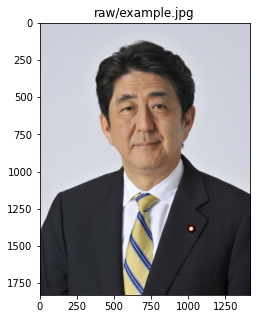

time: 571 ms (started: 2021-01-22 20:16:57 +00:00)


In [ ]:
BLENDED_PATH = '/content/drive/MyDrive/blended_stylegan_simpson.pkl'

Path('raw').mkdir(exist_ok = True, parents = True)
Path('aligned').mkdir(exist_ok = True, parents = True)
Path('generated').mkdir(exist_ok = True, parents = True)

!wget -q https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg -O raw/example.jpg
plotter('raw/example.jpg', title = str('raw/example.jpg'), figsize = (5,5))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path
import pretrained_networks
import gc, os, time, shutil

def run_cmd(cmd): 
  # return subprocess.call(cmd)
  os.system(cmd)

def _delete_all_in_folder(folder):
  for file in Path(folder).glob('*'):
    os.remove(file)

def _authenticate():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  return GoogleDrive(gauth)

# query syntax; https://developers.google.com/drive/api/v2/search-shareddrives
def _get_public_url_from_file_name(file_name, verbose = False):
  my_drive = _authenticate()
  for file in my_drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList():
    if file_name in file['title']:
      # change permissions
      permission = file.InsertPermission({
                        'type': 'anyone',
                        'value': 'anyone',
                        'role': 'reader'})
      if verbose: print(f'{file["title"]} is matching title')
      return str(file['webContentLink'])
  if verbose: print('no matching files')
  return ''

# gdrive empty trash folder
def _gdrive_empty_trash():
  my_drive = _authenticate()
  for a_file in my_drive.ListFile({'q': "trashed = true"}).GetList():
    try: a_file.Delete()
    except: print(f'could not delete {a_file}'); pass
  time.sleep(15) # wait for item to be deleted

def _remove_and_empty_trash(file):
  os.remove(file)
  _gdrive_empty_trash()

def run_simpsonification(model, resolution, blend_width, verbose = False):

  gc.collect()
  if verbose: print(f'blending models...')
  if Path(BLENDED_PATH).exists(): _remove_and_empty_trash(BLENDED_PATH)
  blend_models.main(model,\
                    FFHQ_MODEL,\
                    resolution,\
                    output_pkl=BLENDED_PATH,\
                    blend_width = blend_width, \
                    verbose = verbose)
  time.sleep(15) # wait for model to be uploaded to drive

  if verbose: print(f'loading networks...')
  # blended_url = "https://drive.google.com/uc?id=1-PV4iqH8pLgm2R7wRsL69DkBpbXhAZYh"
  blended_url = _get_public_url_from_file_name('blended_stylegan_simpson', verbose=verbose)
  _, _, Gs_blended = pretrained_networks.load_networks(blended_url)
  _, _, Gs = pretrained_networks.load_networks(ffhq_url)

  if verbose: print(f'aligning and projecting imgs...')
  run_cmd('python align_images.py raw aligned')
  # IMPORTANT: use the same ffhq url as earlier
  run_cmd('python project_images.py --num-steps 500 aligned generated --network-pkl '+str(ffhq_url))
  
  if verbose: print(f'creating simpson img...')
  latent_dir = Path("generated")  
  latents = latent_dir.glob("*.npy")
  # _delete_all_in_folder(latent_dir)
  img_file_names = []
  for latent_file in latents:
    latent = np.load(latent_file)
    latent = np.expand_dims(latent,axis=0)
    synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
    images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
    Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{Path(model).stem}-{resolution}-{blend_width}-simpson.jpg"))
    img_file_names.append(latent_file.parent / (f"{Path(model).stem}-{resolution}-{blend_width}-simpson.jpg"))

  return img_file_names

def copy_to_drive(file, drive_path):
  if Path(drive_path).exists(): Path(drive_path).mkdir(parents = True, exist_ok = True)
  output = str(Path(drive_path)/Path(file).name)
  return shutil.copyfile(str(file), str(output))

# # TODO: this is really inefficient. Can we speed this up?
for model in tqdm(SNAPSHOTS):

  # for blend_width in tqdm([None] + list(range(1, 3))):
  # for resolution in tqdm([32, 64, 128, 256]):

  img_file_names = run_simpsonification(model,\
                                        resolution = 256,\
                                        blend_width = None,\
                                        verbose = False)

  for file in img_file_names: 
    copy_to_drive(file, f'/content/drive/MyDrive/stylegan2/results{RESULTS_ITERATION}_output')
    # plotter(file, title = str(file), figsize = (5,5))

In [ ]:
def get_latest_snapshot():
  files = glob.glob(SNAPSHOTS_PATH)
  return sorted(files, key = lambda x: get_snapshot_number(x))[-1]

# while True:
#   img_file_names = run_simpsonification(get_latest_snapshot(),\
#                                         resolution = 256,\
#                                         blend_width =  None,\
#                                         verbose = False)
#   for file in img_file_names: plotter(file, title = file, figsize = (5,5))
#   time.sleep(15)


In [ ]:
from math import ceil
from io import BytesIO
import IPython.display
import glob
import numpy as np
from pathlib import Path
import PIL
import os

# taken from stylegan
def createImageGrid(images, scale=0.25, rows=1):
  w,h = images[0].size
  w = int(w*scale)
  h = int(h*scale)
  height = rows*h
  cols = ceil(len(images) / rows)
  width = cols*w
  canvas = PIL.Image.new('RGBA', (width,height), 'white')
  for i,img in enumerate(images):
    img = img.resize((w,h), PIL.Image.ANTIALIAS)
    canvas.paste(img, (w*(i % cols), h*(i // cols))) 
  return canvas

# taken from stylegan 
def imshow_func(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
            'trying jpeg instead.').format(format)
      return imshow_func(a, format='jpeg')
    else:
      raise
  return disp

def sort_imgs(files):
  # sort imgs by model, then resolution, then blend width
  
  for file in files:
    if 'None' in file: os.rename(file, file.replace('None', '0'))

  files = [i.replace('None', '0') for i in files]
  sorted_files = sorted(files, key = lambda x: \
                (
                  int(Path(x).stem.split('-')[2]),\
                  int(Path(x).stem.split('-')[3]),\
                  int(Path(x).stem.split('-')[4]),\
                )
          )
  return sorted_files

def plot_img_grid(scale = 1):
  files = glob.glob('/content/stylegan2/generated/*.jpg')
  rows = len(glob.glob('/content/stylegan2/generated/*000024*.jpg'))
  print(rows)
  full_list = [PIL.Image.open(i) for i in sort_imgs(files)]
  imshow_func(createImageGrid(full_list, rows = rows, scale = scale))


13


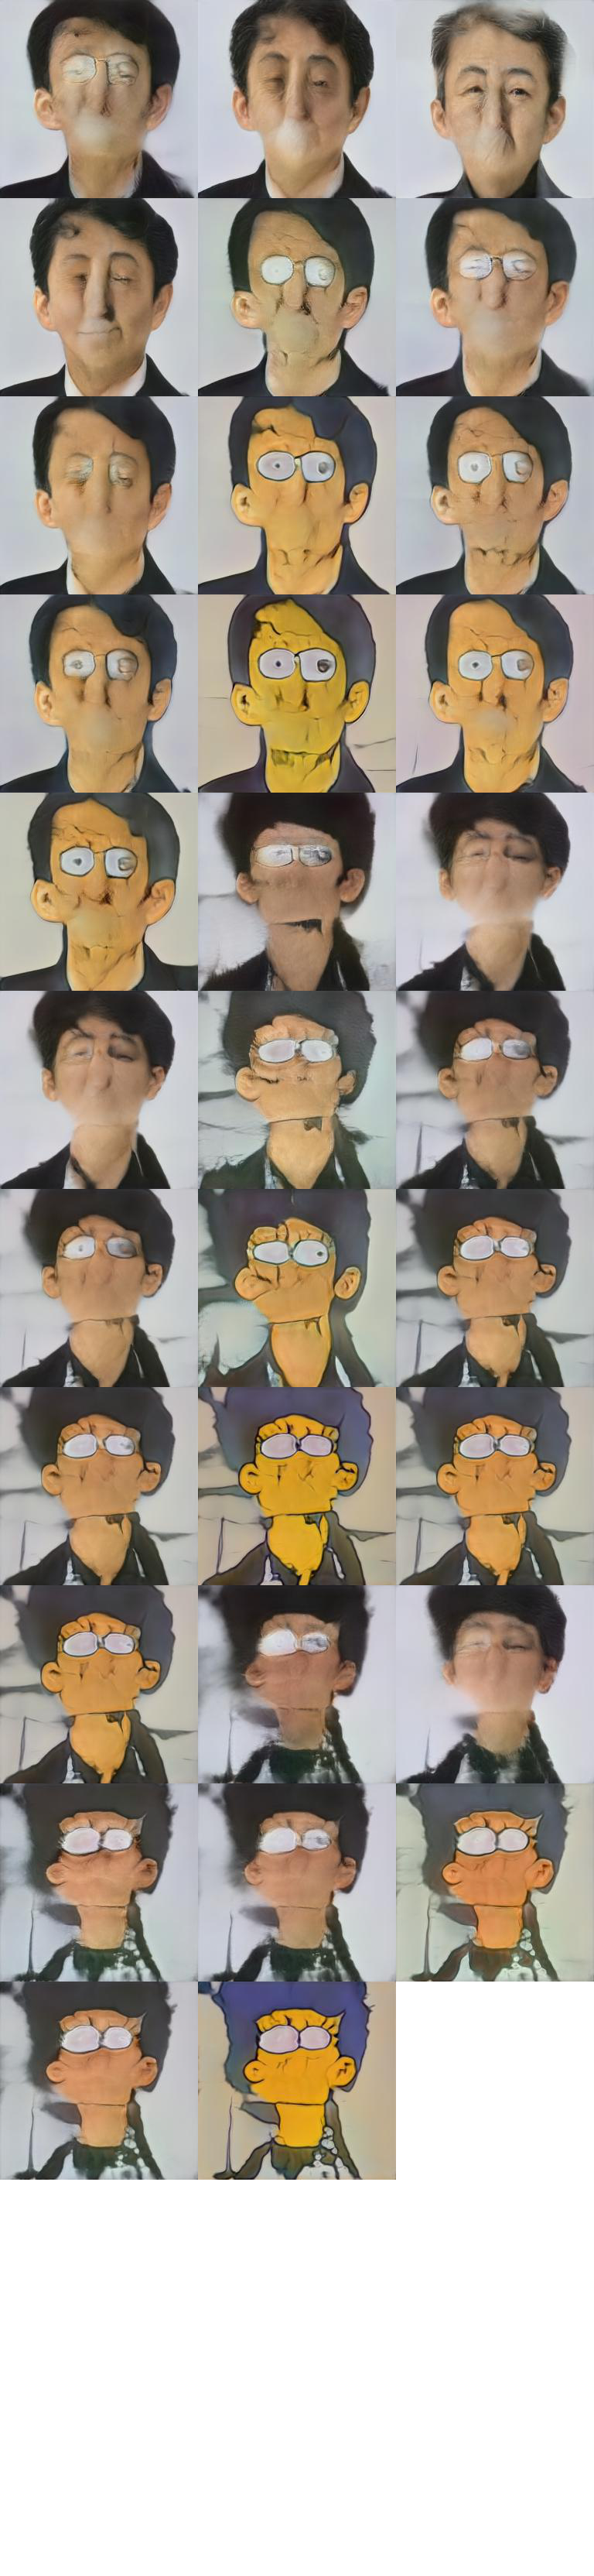

In [ ]:
plot_img_grid()